# Lesson 0046 - MNIST Generative Adversarial Networks
In this lesson, we will attempt to create numbers from the MNIST data set as in [lesson_0044](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0044_mnist_variational_autoencoder.ipynb), however, this time, we will employ a generative adversarial network (GAN). The idea of a GAN is the following: consider a policeperson and a counterfeiter. The counterfeiter tries to counterfeit bills, and the policeperson tries to detect counterfeited bills. Therefore, one can train both concurrently. As the policeperson gets better with identifying counterfeited bills, the counterfeiter has to improve his/her ability to counterfeit. Given both long enough time to train, the counterfeiter will create bills, that look perfectly like the original bills, and therefore, the policeperson cannot differentiate the counterfeited from the true one.<br>
Therefore, we will create two neural networks: the __creator__ and the __critic__.<br>
We begin with stealing code from [lesson_0044](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0044_mnist_variational_autoencoder.ipynb).

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


We do not need a test set, since we will feed the __critic__ images and just ask, if the image is a real image or not. Therefore, we will load the images from the training set into __train__ and only work with these images.

In [2]:
( train, _ ),( test_x, test_y ) = tf.keras.datasets.mnist.load_data()

In [3]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [5]:
mu = np.mean( train )

sigma = np.std( train )



train = ( train - mu ) / sigma



train = np.reshape( train, [ 60000, 28, 28, 1 ] )

In [6]:
import keras
from keras import models
from keras import layers
from keras import backend as K

print( keras.__version__ )

2.2.4


Using TensorFlow backend.


The __critic__ is a simple convolutional neural network with only one output node, because for a given input image, when are only interested whether the image is real or fake.

In [7]:
critic_input = keras.engine.input_layer.Input( shape = ( 28, 28, 1, ) )

critic_layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), strides = 2, 
                              padding = "SAME" )( critic_input )

critic_layer2 = layers.Dropout( 0.4 )( critic_layer1 )

critic_layer3 = layers.Conv2D( 128, 5, activation = layers.LeakyReLU( alpha = 0.3 ), strides = 2, 
                              padding = "SAME" )( critic_layer2 )

critic_layer4 = layers.Dropout( 0.4 )( critic_layer3 )

critic_layer5 = layers.Flatten()( critic_layer4 )

critic_layer6 = layers.Dense( 1 )( critic_layer5 )





critic = keras.Model( critic_input, critic_layer6 )

critic.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)  

C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Now, we define the [Wasserstein Loss](https://arxiv.org/abs/1506.05439).<br>
We employ this __loss__ in both the __critic__ and the __creator__.

In [8]:
def wasserstein( y_true, y_pred ):
    
    return K.mean( y_true * y_pred )

In [9]:
critic.compile( optimizer = keras.optimizers.SGD( lr = 0.00005, momentum = 0, decay = 0,nesterov = False ), 
               loss = wasserstein, metrics = None )

In the __creator__, we employ [BatchNormalization layers](https://keras.io/layers/normalization/) that map the input to normalized data.<br>
The __creator__ takes $100$ random numbers as input and generates a $28*28*1$ image as output.

In [10]:
creator_input = keras.engine.input_layer.Input( shape = ( 100, ) )

creator_layer1 = layers.Dense( 7 * 7 * 64 )( creator_input )

creator_layer2 = layers.BatchNormalization()( creator_layer1 )

creator_layer3 = layers.LeakyReLU()( creator_layer2 )

creator_layer4 = layers.Reshape( ( 7, 7, 64 ) )( creator_layer3 )

creator_layer5 = layers.UpSampling2D()( creator_layer4 )

creator_layer6 = layers.Conv2D( 128, 5, activation = layers.LeakyReLU( alpha = 0.3 ), strides = 1, 
                              padding = "SAME" )( creator_layer5 )

creator_layer7 = layers.BatchNormalization()( creator_layer6 )

creator_layer8 = layers.LeakyReLU()( creator_layer7 )

creator_layer9 = layers.UpSampling2D()( creator_layer8 )

creator_layer10 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), strides = 1, 
                              padding = "SAME" )( creator_layer9 )

creator_layer11 = layers.BatchNormalization()( creator_layer10 )

creator_layer12 = layers.LeakyReLU()( creator_layer11 )

creator_layer13 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), strides = 1, 
                              padding = "SAME" )( creator_layer12 )

creator_layer14 = layers.BatchNormalization()( creator_layer13 )

creator_layer15 = layers.LeakyReLU()( creator_layer14 )

creator_layer16 = layers.Conv2D( 1, 5, activation = layers.LeakyReLU( alpha = 0.3 ), strides = 1, 
                              padding = "SAME" )( creator_layer15 )




creator = keras.Model( creator_input, creator_layer16 )

creator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       204928    
__________

When we train the __creator__, we train the __creator__ in conjunction with the __critic__, because we want the __creator__ to improve in its skill to fool the __critic__. Therefore, the weights in the __critic__ are to be frozen.

In [11]:
critic.trainable = False

creator_trainer = keras.Model( creator_input, critic( creator( creator_input ) ) )

creator_trainer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         844161    
_________________________________________________________________
model_1 (Model)              (None, 1)                 212865    
Total params: 1,057,026
Trainable params: 837,377
Non-trainable params: 219,649
_________________________________________________________________


In [12]:
creator_trainer.compile( optimizer = keras.optimizers.SGD( lr = 0.0001, momentum = 0, decay = 0,nesterov = False ), 
               loss = wasserstein, metrics = None )

Now, we define to functions to perform the training of the __creator__ and the __critic__. We employ [train_on_batch](https://keras.io/models/sequential/).<br>
For the __creator__, we create random noise, and train the __creator__ with a frozen __critc__, so that the __critic__ interpretes the image created by the __creator__ as a true image.

In [13]:
def train_creator():
    
    valid = np.zeros( [ 100 ] ) + 1.0
    
    noise = np.random.normal( 0, 1, ( 100, 100 ) )
    
    loss = creator_trainer.train_on_batch( noise, valid )
    
    return loss

The __critic__ is trained with both, real and fake data. The weights of the __critic__ are then clipped to the range $-0.01$ to $0.01$.

In [14]:
def train_critic():
    
    valid = np.zeros( [ 100 ] ) + 1.0
    
    random_integers = np.random.choice( range( 60000 ), 100, replace = False )
    
    true_images = train[ random_integers, :, :, : ]
    
    
    
    loss_real = critic.train_on_batch( true_images, valid )

    
    
    
    invalid = np.zeros( [ 100 ] ) - 1.0
    
    noise = np.random.normal( 0, 1, ( 100, 100 ) )
    
    

    
    loss_fake = critic.train_on_batch( creator.predict( noise ), invalid )
    
    
    
    
    for l in critic.layers:
        
        weights = l.get_weights()
        
        weights = [ np.clip( w, -0.01, 0.01 ) for w in weights ]
        
        l.set_weights( weights )
        
    return loss_real, loss_fake

Now, we set up the training. For each step in the training, we train the __creator__ once, and the __critic__ $5$ times. This forces the __critic__ to become able to differentiate between real images and fake, and this in turn forces the __creator__ to mimic the real data.

In [15]:
loss_creator = []

loss_critic_real = []

loss_critic_fake = []

loss_critic_combined = []





for i in range( 400000 ):
    
    critic.trainable = True
    
    train_critic()
    
    train_critic()
    
    train_critic()
    
    train_critic()
    
    loss = train_critic()
    
    
    
    
    critic.trainable = False
    
    loss_critic_real.append( loss[ 0 ] )
    
    loss_critic_fake.append( loss[ 1 ] )
    
    loss_critic_combined.append( ( loss[ 0 ] + loss[ 1 ] ) / 2.0 )
    
    
    
    
    loss = train_creator()
    
    
    
    
    loss_creator.append( loss )

Instructions for updating:
Use tf.cast instead.


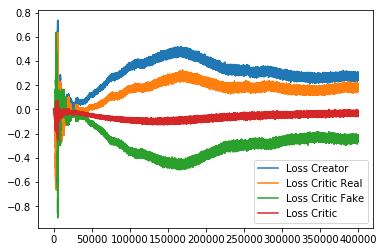

In [16]:
plt.plot( loss_creator, label = "Loss Creator" )

plt.plot( loss_critic_real, label = "Loss Critic Real" )

plt.plot( loss_critic_fake, label = "Loss Critic Fake" )

plt.plot( loss_critic_combined, label = "Loss Critic" )

plt.legend( loc = "best" )

Now, let's create images.

([], <a list of 0 Text yticklabel objects>)

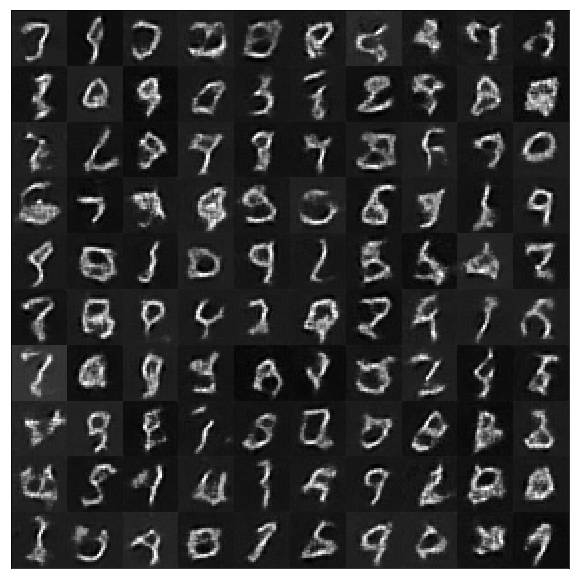

In [17]:
mat = np.zeros( shape = [ 280, 280 ] )



for i in range( 10 ):
    
    for j in range( 10 ):
        
        x_d = i * 28
        
        x_u = 28 + i * 28
        
        y_l = j * 28
        
        y_r = 28 + j * 28
        
        pred = creator.predict( np.random.normal( 0, 1, ( 1, 100 ) ) )[ 0, :, :, 0 ]
        
        pred = pred - np.min( pred )
        
        pred = pred / np.max( pred )
        
        mat[ x_d : x_u, y_l : y_r ] = pred
        

        
plt.figure( 1, figsize = ( 10, 10 ) )
        
plt.matshow( mat, cmap = plt.cm.gray, fignum = 1 )

plt.xticks( [ ] )

plt.yticks( [ ] )